In [1]:
import os
os.chdir("..")

In [15]:
from src.data.data_process import DataReg
import polars as pl
import matplotlib.dates as mdates
import geopandas as gpd
from mapclassify import Quantiles
import pandas as pd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
dr = DataReg()

In [3]:
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)
pr_zips

,zipcode,geometry
0,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127..."
1,00769,"POLYGON ((-66.43156 18.06363, -66.43154 18.063..."
2,00667,"POLYGON ((-67.11587 18.03177, -67.11586 18.031..."
3,00953,"POLYGON ((-66.31914 18.37159, -66.31907 18.371..."
4,00612,"POLYGON ((-66.77634 18.42192, -66.77625 18.422..."
...,...,...
133,00830,"MULTIPOLYGON (((-64.79979 18.32668, -64.79975 ..."
134,00802,"POLYGON ((-65.0569 18.36322, -65.05686 18.3632..."
135,00851,"POLYGON ((-64.79312 17.74961, -64.79036 17.750..."
136,00820,"MULTIPOLYGON (((-64.70353 17.74936, -64.70352 ..."


In [13]:
df = pl.read_parquet("data/impact.parquet").with_columns(pl.col("zipcode").str.replace("zip_",""))
gdf = pr_zips.join(
                df.to_pandas().set_index("zipcode"), on="zipcode", how="inner"
        ).reset_index(drop=True)
gdf

,zipcode,geometry,impact
0,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2366.542
1,00769,"POLYGON ((-66.43156 18.06363, -66.43154 18.063...",-2666.310
2,00667,"POLYGON ((-67.11587 18.03177, -67.11586 18.031...",-8284.737
3,00953,"POLYGON ((-66.31914 18.37159, -66.31907 18.371...",3621.952
4,00612,"POLYGON ((-66.77634 18.42192, -66.77625 18.422...",4476.906
...,...,...,...
127,00784,"POLYGON ((-66.22536 17.9254, -66.225 17.92604,...",-5305.773
128,00925,"POLYGON ((-66.05658 18.40773, -66.05648 18.407...",27808.447
129,00985,"POLYGON ((-65.97403 18.38888, -65.97388 18.389...",941.098
130,00969,"MULTIPOLYGON (((-66.1287 18.38094, -66.12835 1...",15505.076


<Axes: >

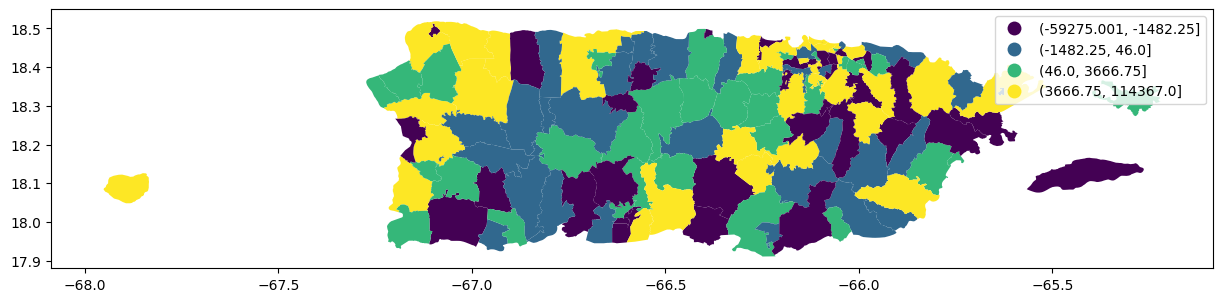

In [23]:
# Assuming gdf is your GeoDataFrame
data = gdf["impact"].round()

# Define custom bins such that 0 is in the center
quantile_values = np.percentile(data[data != 0], [0, 25, 50, 75, 100])

# Make sure 0 is in the middle, adjust bins around it
bins = list(quantile_values)

# Create a custom classification using Quantiles
classifier = Quantiles(data, k=len(bins)-1)

# Manually assign the bins to the GeoDataFrame based on your custom bins
gdf["impact_bins"] = pd.cut(data, bins=bins, include_lowest=True)

# Plot with custom binning and 'viridis' colormap
gdf.plot(
    column="impact_bins",
    legend=True,
    figsize=(15, 10),
    cmap='viridis',  # Apply the 'viridis' colormap
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)